In [2]:
import os
import datetime
import pandas as pd
import empyrical as empy
from sklearn.metrics import accuracy_score, precision_score

In [3]:
# include the date
# start_date = datetime.date(2008, 1, 1)
start_date = datetime.date(2008, 1, 1)
end_date = datetime.date(2021, 12, 14)

In [4]:
def parse_date(df, start_date, end_date):
    if start_date is not None:
        df = df[df.index >= start_date]
    if end_date is not None:
        df = df[df.index <= end_date]
    return df

In [7]:
def calculate_metrics(preds, y, start_date, end_date):
    preds = parse_date(preds, start_date, end_date)
    print("preds: {} to {}".format(preds.index[0], preds.index[-1]))
    sub_acc = pd.DataFrame(index=preds.columns)
    for case in preds.columns:
        sub_preds = preds[case]
        tmp = pd.concat([sub_preds, y], axis=1).dropna()
        sub_acc.loc[case, 'accuracy'] = accuracy_score(tmp.iloc[:, 1], tmp.iloc[:, 0])
        sub_acc.loc[case, 'precision'] = precision_score(tmp.iloc[:, 1], tmp.iloc[:, 0])
    return sub_acc

def get_label(dfclose, pp=21):
    dfclose.index = pd.to_datetime(dfclose.index, format='%Y-%m-%d').date
    y_pctch = -dfclose.pct_change(-pp).dropna(how='all')
    y_label = (y_pctch > 0).astype(int)
    return y_label

In [10]:
price = pd.read_csv('XAU_USD.csv', index_col=0)['adj_close']
ret = price.pct_change(1).dropna()

## xgb EMA

In [47]:
def get_xgbEMA_result(case):
    preds = pd.read_csv("20220216-result/y_dualmom_{}.csv".format(case), index_col=0)['y_preds']
    preds.index = pd.to_datetime(preds.index, format="%Y-%m-%d").date
    preds.name = case
    return preds

In [48]:
xgbEMA_preds = pd.read_csv("20220216-result/preds_summary.csv", index_col=0)
xgbEMA_preds.index = pd.to_datetime(xgbEMA_preds.index, format="%Y-%m-%d").date
xgbEMA_acc = calculate_metrics(xgbEMA_preds, y, start_date, end_date)

preds: 2015-06-01 to 2021-12-14


In [49]:
xgbEMA_acc_top10 = xgbEMA_acc.sort_values('accuracy', ascending=False)[:10]
xgbEMA_precision_top10 = xgbEMA_acc.sort_values('precision', ascending=False)[:10]
top10_case = list(set(list(xgbEMA_acc_top10.index) + list(xgbEMA_precision_top10.index)))
xgbEMA_top10 = xgbEMA_acc.loc[top10_case, :]
xgbEMA_top10

,accuracy,precision
EMA3&EMA13,0.555751,0.675556
EMA1&EMA21,0.540493,0.622677
EMA1&EMA3,0.546948,0.591083
EMA144&EMA610,0.574531,0.607223
EMA21&EMA233,0.546948,0.632163
EMA89&EMA987,0.552817,0.582524
EMA34&EMA233,0.559272,0.619186
EMA1&EMA13,0.541667,0.635628
EMA3&EMA5,0.578052,0.627604
EMA21&EMA610,0.575704,0.615385


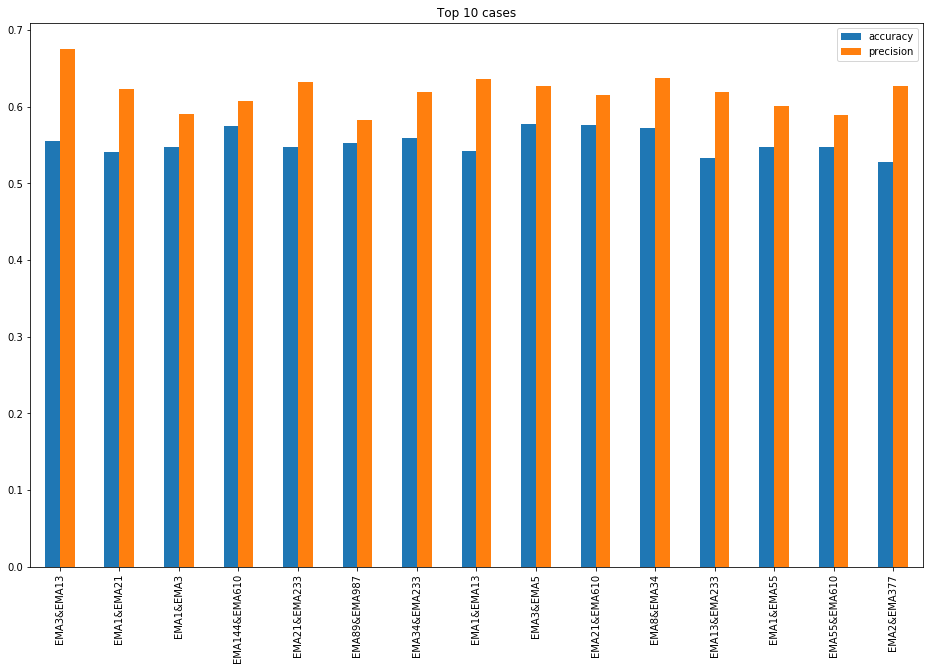

In [50]:
xgbEMA_top10.plot(kind='bar', title='Top 10 cases', figsize=(16, 10))

In [51]:
xgbEMApair_cases = ['allEMA&21D', 'allEMA_cross&21D', 'allEMA_crossONLY&21D']
xgbEMApair_preds = pd.DataFrame()
for case in xgbEMApair_cases:
    preds = get_xgbEMA_result(case)
    xgbEMApair_preds = pd.concat([xgbEMApair_preds, preds], axis=1)
# xgbEMApair_preds

In [52]:
xgbEMApair_acc = calculate_metrics(xgbEMApair_preds, y, start_date, end_date)
xgbEMApair_acc

preds: 2015-06-01 to 2021-12-14


,accuracy,precision
allEMA&21D,0.518779,0.565698
allEMA_cross&21D,0.504695,0.543452
allEMA_crossONLY&21D,0.447183,0.482260


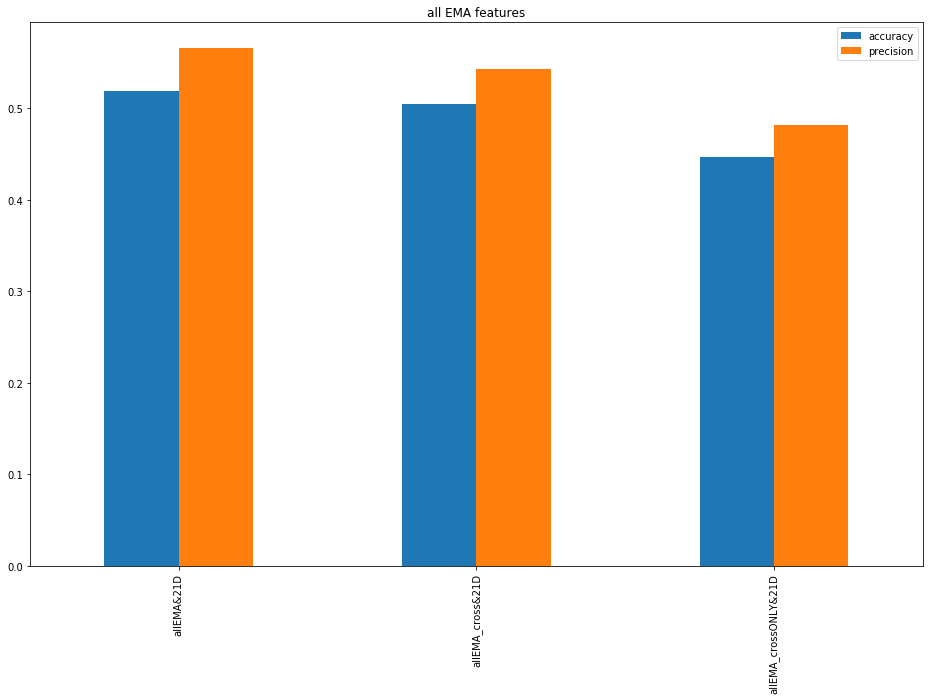

In [61]:
xgbEMApair_acc.plot(kind='bar', title='all EMA features', figsize=(16, 10))

## ML as pipeline

### individual models

In [54]:
def get_preds(file):
    df = pd.read_csv(file, index_col=0, header=1)
    df.index = pd.to_datetime(df.index).date
    return df

In [55]:
preds_folder = 'ML-result'
file = os.path.join(preds_folder, 'Top5NNLow1', 'XAUUSD_all_preds.csv')
model_preds = get_preds(file)
# model_preds

In [56]:
model_acc = calculate_metrics(model_preds, y, start_date, end_date)
model_acc

preds: 2015-06-01 to 2021-12-14


c:\users\ho sumwai\appdata\local\programs\python\python36-64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,accuracy,precision
sk_lgb_6Y,0.520315,0.528409
sk_rfc_6Y,0.524560,0.531845
sk_lgr_6Y,0.526380,0.532808
sk_svc_6Y,0.485143,0.522663
sk_rgc_6Y,0.548817,0.580494
nn_base_6Y,0.491207,0.520548
nn_fuzz_6Y,0.499697,0.525688
nn_one_6Y,0.540934,0.566667
nn_two_6Y,0.465737,0.000000
nn_three_6Y,0.497271,0.524119


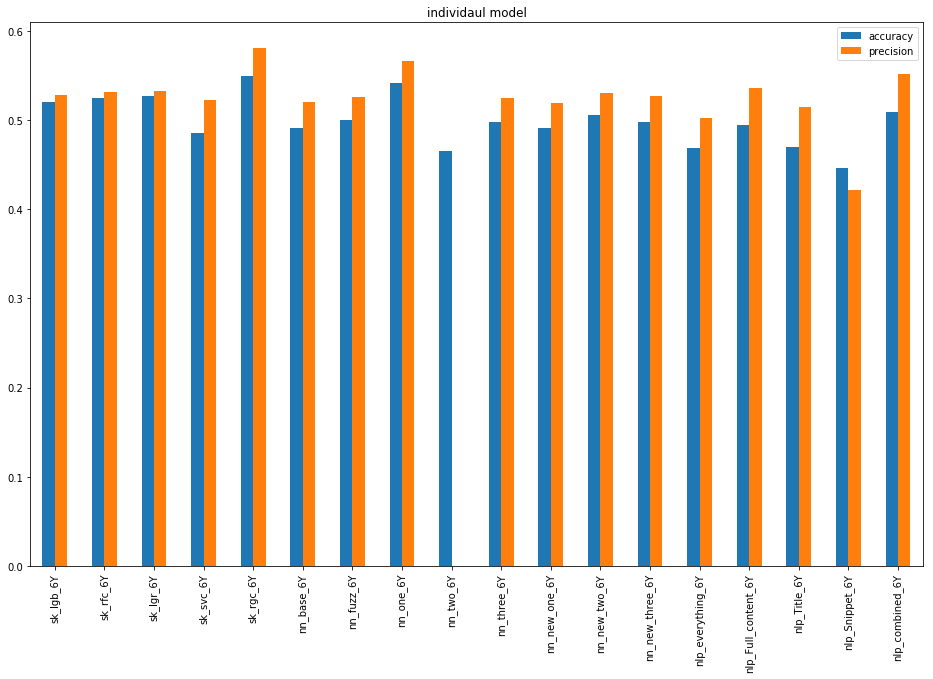

In [57]:
model_acc.plot(kind='bar', title='individaul model', figsize=(16, 10))

### model ensemble

In [58]:
folder = 'ML-result'
ensemble_preds = pd.DataFrame()
for fn in os.listdir(folder):
    fpath = os.path.join(folder, fn, 'XAUUSD_preds.csv')
    ser = get_preds(fpath)['Simple Voting']
    ser.name = fn
    ensemble_preds = pd.concat([ensemble_preds, ser], axis=1)
# ensemble_preds

In [59]:
ensemble_acc = calculate_metrics(ensemble_preds, y, start_date, end_date)
ensemble_acc

preds: 2015-06-01 to 2021-12-14


,accuracy,precision
Top3AllLow2,0.480898,0.521589
Top3NNLow2,0.473014,0.505650
Top5,0.450576,0.484885
Top5AllLow1,0.463918,0.498429
Top5NNLow1,0.486355,0.516038
VoteAll_nlp,0.480291,0.531088
VoteAll_nn,0.517890,0.540338
VoteAll_sk,0.516677,0.528378


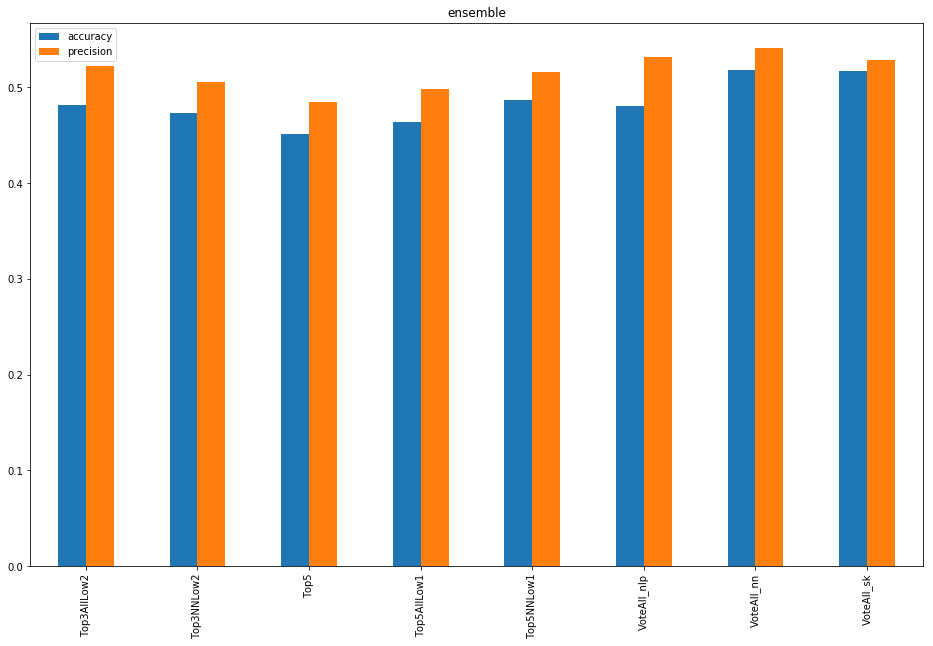

In [60]:
ensemble_acc.plot(kind='bar', title='ensemble', figsize=(16, 10))